# pre Module 3 - Clip WaPOR data to Area of Interest (AOI)
This Notebook allows for clipping the WaPOR data to an Area of Interest, optional before running Module 3 - Calculating Irrigation Performance Assessment Indicators. The script contains the following steps:
* Step a - Import modules/libraries
* Step b - Clip WaPOR data to boundary (using shapefile)

**=====================================================================================================================**

![title](https://raw.githubusercontent.com/wateraccounting/WaPORIPA/main/images/Clip_image.png)

**=====================================================================================================================**

Before you start running this Notebook, make sure you have the following information:

*   Seasonal outputs from module 1 (AETI, T, TBP) and module 2 (RET, PCP, potET)

*   Shapefile with the Area of Interest (AOI)

Step a - Import modules/libraries

In [1]:
!pip install rasterio --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 39.2 MB/s eta 0:00:00


In [5]:
import os
import rasterio
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import geopandas as gpd
from shapely.geometry import box
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import glob

Step b - Clip using project boundary

to mount to google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


or upload files to temporary folder (data to clip and shapefile for clipping)

In [ ]:
#To upload file.
from google.colab import files
uploaded = files.upload()

# Import the shapefile of AOI

In [44]:
shapefile = '/content/drive/MyDrive/WaPOR_IPA/Data/fields/Wad_Hilal_Block_Boundary.shp'

''

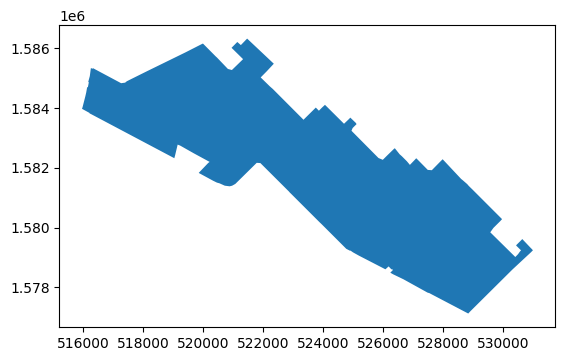

In [45]:
# Plot the AOI
gdf = gpd.read_file(shapefile)
gdf.plot()
gdf
,

Define function to clip raster files with a shapefile

In [47]:
# Function to Clip a raster, and reproject the shapefile if projection is different

def reproject_shapefile(shapefile, dst_crs):
    # Read the shapefile
    gdf = gpd.read_file(shapefile)
    # Reproject to the destination CRS
    gdf = gdf.to_crs(dst_crs)
    return gdf

def clip_rasters_with_shapefile(input_folder, shapefile, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Read the shapefile
    gdf = gpd.read_file(shapefile)

    clipped_files = []

    for raster_file in os.listdir(input_folder):
        if raster_file.endswith('.tif'):
            raster_path = os.path.join(input_folder, raster_file)
            with rasterio.open(raster_path) as src:
                # Reproject shapefile if needed
                if gdf.crs != src.crs:
                    gdf = reproject_shapefile(shapefile, src.crs)

                # Get the geometry in the format required by rasterio.mask
                shapes = [feature["geometry"] for feature in gdf.__geo_interface__["features"]]

                # Clip the raster
                out_image, out_transform = mask(src, shapes, crop=True)
                out_meta = src.meta.copy()
                out_meta.update({
                    "driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform,
                    "crs": src.crs
                })

                # Save the clipped raster
                output_raster_path = os.path.join(output_folder, raster_file)
                with rasterio.open(output_raster_path, "w", **out_meta) as dest:
                    dest.write(out_image)

                clipped_files.append(output_raster_path)

    return clipped_files

# Clip Seasonal RET raster

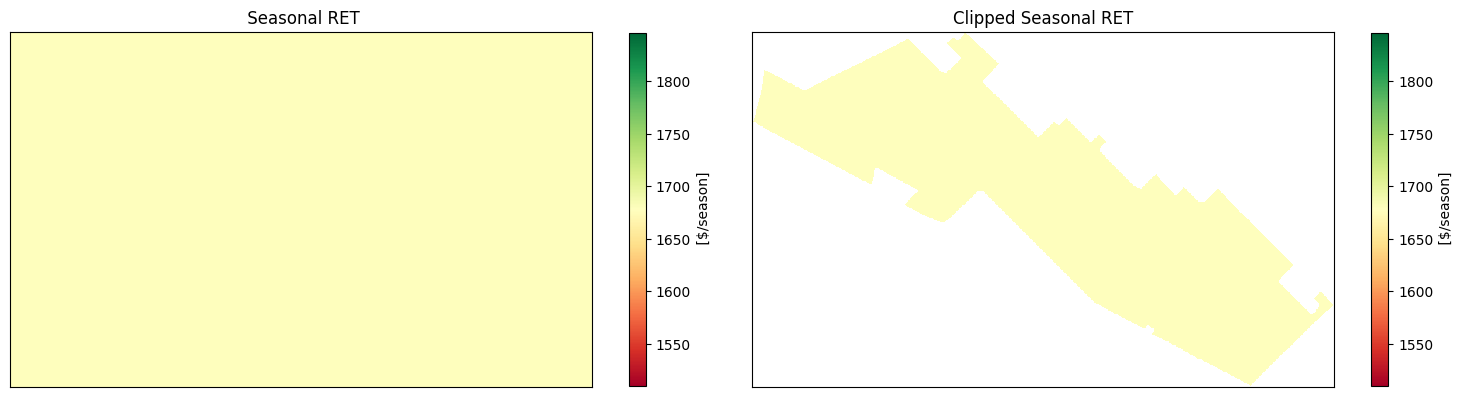

In [49]:
# Define paths
input_folder = '/content/drive/MyDrive/WaPOR_IPA/Data/L1-RET-season_resampled'
input_fhs   = glob.glob(input_folder + '/*.tif')

output_folder = '/content/drive/MyDrive/WaPOR_IPA/Data/L1-RET-season_resampled_Clipped'
output_fhs    = glob.glob(output_folder + '/*.tif')

if not os.path.exists(output_folder):
    os.makedirs(output_folder)


# Open the raster file
Season_tif = rio.open(input_fhs[0])
Season_data = Season_tif.read(1)

# Clip rasters
clipped_files = clip_rasters_with_shapefile(input_folder, shapefile, output_folder)

# Open the clipped raster file
with rio.open(output_fhs[0]) as Clipped:
    Clipped_data = Clipped.read(1)

    # Mask the -9999 values
    Clipped_data = np.ma.masked_equal(Clipped_data, -9999)

# Plot the data side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Original data
axs[0].imshow(Season_data, cmap='RdYlGn')
axs[0].set_title(' Seasonal RET')
axs[0].set_xticks([])
axs[0].set_yticks([])
cbar = fig.colorbar(axs[0].images[0], ax=axs[0], shrink=0.75, label=' [$/season]')

# Clipped data
axs[1].imshow(Clipped_data, cmap='RdYlGn')
axs[1].set_title('Clipped Seasonal RET')
axs[1].set_xticks([])
axs[1].set_yticks([])
cbar = fig.colorbar(axs[1].images[0], ax=axs[1], shrink=0.75, label=' [$/season]')

plt.tight_layout()
plt.show()


# Clip Seasonal Precipitation raster

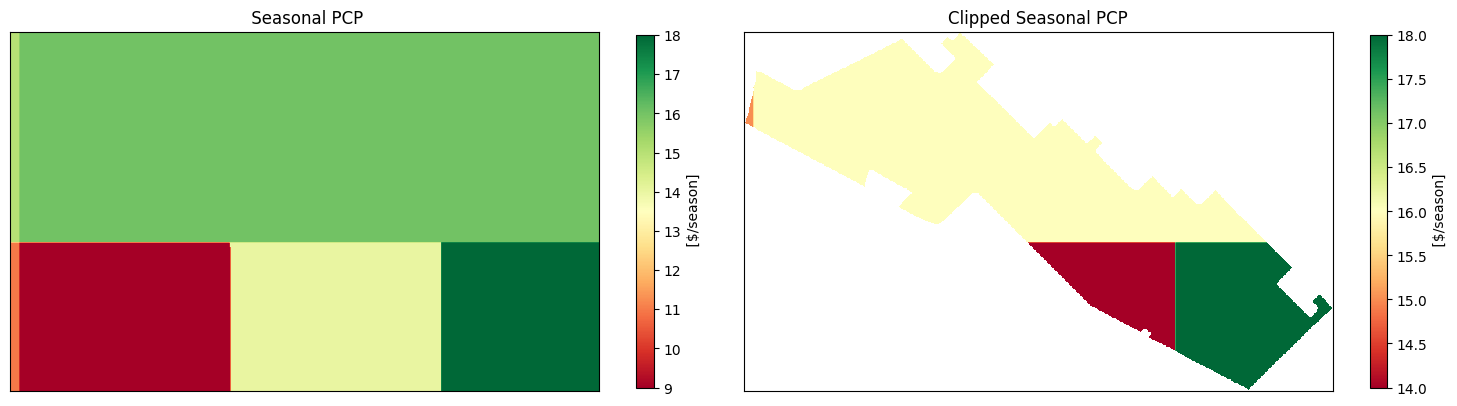

In [36]:
# Define paths
input_folder = '/content/drive/MyDrive/WaPOR_IPA/Data/L1-PCP-season_resampled'
input_fhs   = glob.glob(input_folder + '/*.tif')

output_folder = '/content/drive/MyDrive/WaPOR_IPA/Data/L1-PCP-D_resampled_Clipped'
output_fhs    = glob.glob(output_folder + '/*.tif')

if not os.path.exists(output_folder):
    os.makedirs(output_folder)


# Open the raster file
Season_tif = rio.open(input_fhs[0])
Season_data = Season_tif.read(1)

# Clip rasters
clipped_files = clip_rasters_with_shapefile(input_folder, shapefile, output_folder)


# Refresh the list of output files
output_fhs = glob.glob(output_folder + '/*.tif')


# Open the clipped raster file
with rio.open(output_fhs[0]) as Clipped:
    Clipped_data = Clipped.read(1)

    # Mask the -9999 values
    Clipped_data = np.ma.masked_equal(Clipped_data, -9999)

# Plot the data side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Original data
axs[0].imshow(Season_data, cmap='RdYlGn')
axs[0].set_title(' Seasonal PCP')
axs[0].set_xticks([])
axs[0].set_yticks([])
cbar = fig.colorbar(axs[0].images[0], ax=axs[0], shrink=0.75, label=' [$/season]')

# Clipped data
axs[1].imshow(Clipped_data, cmap='RdYlGn')
axs[1].set_title('Clipped Seasonal PCP')
axs[1].set_xticks([])
axs[1].set_yticks([])
cbar = fig.colorbar(axs[1].images[0], ax=axs[1], shrink=0.75, label=' [$/season]')

plt.tight_layout()
plt.show()


# Clip Seasonal NPP raster

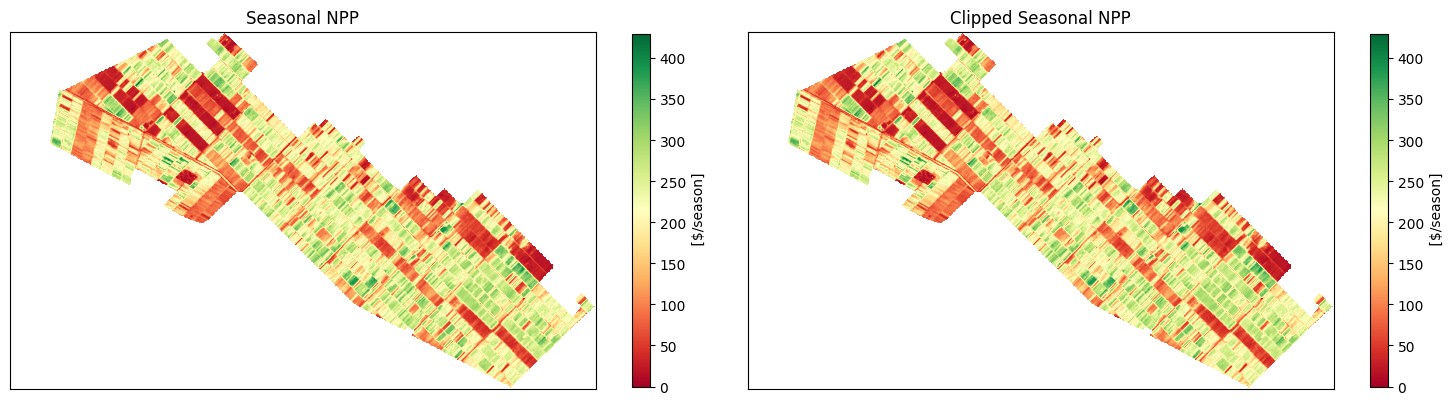

In [51]:
# Define paths
input_folder = '/content/drive/MyDrive/WaPOR_IPA/Data/NPP_season'
input_fhs   = glob.glob(input_folder + '/*.tif')

output_folder = '/content/drive/MyDrive/WaPOR_IPA/Data/NPP_season_clipped'
output_fhs    = glob.glob(output_folder + '/*.tif')

if not os.path.exists(output_folder):
    os.makedirs(output_folder)


# Open the raster file
Season_tif = rio.open(input_fhs[0])
Season_data = Season_tif.read(1)

# Clip rasters
clipped_files = clip_rasters_with_shapefile(input_folder, shapefile, output_folder)

# Refresh the list of output files
output_fhs = glob.glob(output_folder + '/*.tif')

# Open the clipped raster file
with rio.open(output_fhs[0]) as Clipped:
    Clipped_data = Clipped.read(1)

    # Mask the -9999 values
    Clipped_data = np.ma.masked_equal(Clipped_data, -9999)

# Plot the data side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Original data
axs[0].imshow(Season_data, cmap='RdYlGn')
axs[0].set_title('Seasonal NPP')
axs[0].set_xticks([])
axs[0].set_yticks([])
cbar = fig.colorbar(axs[0].images[0], ax=axs[0], shrink=0.75, label=' [$/season]')

# Clipped data
axs[1].imshow(Clipped_data, cmap='RdYlGn')
axs[1].set_title('Clipped Seasonal NPP')
axs[1].set_xticks([])
axs[1].set_yticks([])
cbar = fig.colorbar(axs[1].images[0], ax=axs[1], shrink=0.75, label=' [$/season]')

plt.tight_layout()
plt.show()

#  Clip Seasonal AETI raster

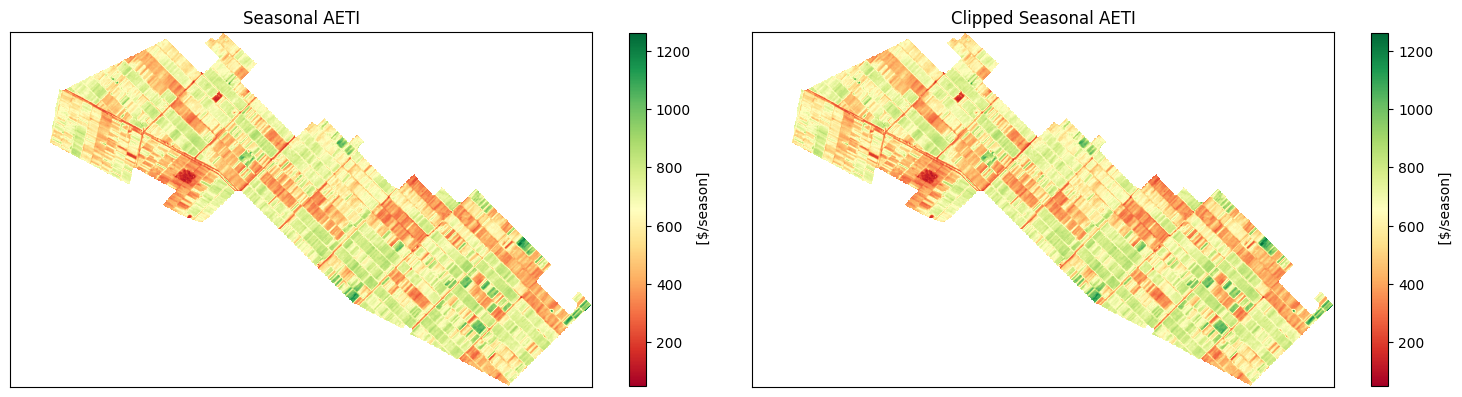

In [38]:
# Define paths
input_folder = '/content/drive/MyDrive/WaPOR_IPA/Data/AETI_season'
input_fhs   = glob.glob(input_folder + '/*.tif')

output_folder = '/content/drive/MyDrive/WaPOR_IPA/Data/AETI_season_clipped'
output_fhs    = glob.glob(output_folder + '/*.tif')

if not os.path.exists(output_folder):
    os.makedirs(output_folder)


# Open the raster file
Season_tif = rio.open(input_fhs[0])
Season_data = Season_tif.read(1)

# Clip rasters
clipped_files = clip_rasters_with_shapefile(input_folder, shapefile, output_folder)

# Refresh the list of output files
output_fhs = glob.glob(output_folder + '/*.tif')

# Open the clipped raster file
with rio.open(output_fhs[0]) as Clipped:
    Clipped_data = Clipped.read(1)

    # Mask the -9999 values
    Clipped_data = np.ma.masked_equal(Clipped_data, -9999)

# Plot the data side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Original data
axs[0].imshow(Season_data, cmap='RdYlGn')
axs[0].set_title('Seasonal AETI')
axs[0].set_xticks([])
axs[0].set_yticks([])
cbar = fig.colorbar(axs[0].images[0], ax=axs[0], shrink=0.75, label=' [$/season]')

# Clipped data
axs[1].imshow(Clipped_data, cmap='RdYlGn')
axs[1].set_title('Clipped Seasonal AETI')
axs[1].set_xticks([])
axs[1].set_yticks([])
cbar = fig.colorbar(axs[1].images[0], ax=axs[1], shrink=0.75, label=' [$/season]')

plt.tight_layout()
plt.show()

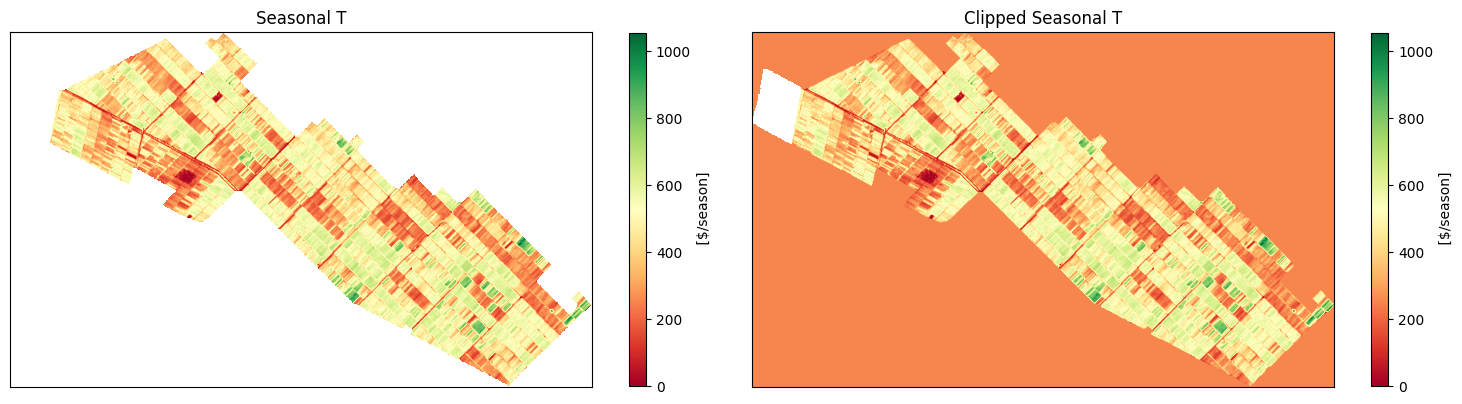

In [39]:
# Define paths
input_folder = '/content/drive/MyDrive/WaPOR_IPA/Data/T_season'
input_fhs   = glob.glob(input_folder + '/*.tif')

output_folder = '/content/drive/MyDrive/WaPOR_IPA/Data/T_season_clipped'
output_fhs    = glob.glob(output_folder + '/*.tif')

if not os.path.exists(output_folder):
    os.makedirs(output_folder)


# Open the raster file
Season_tif = rio.open(input_fhs[0])
Season_data = Season_tif.read(1)

# Clip rasters
clipped_files = clip_rasters_with_shapefile(input_folder, shapefile, output_folder)

# Refresh the list of output files
output_fhs = glob.glob(output_folder + '/*.tif')

# Open the clipped raster file
with rio.open(output_fhs[0]) as Clipped:
    Clipped_data = Clipped.read(1)

    # Mask the -9999 values
    Clipped_data = np.ma.masked_equal(Clipped_data, -9999)

# Plot the data side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Original data
axs[0].imshow(Season_data, cmap='RdYlGn')
axs[0].set_title('Seasonal T')
axs[0].set_xticks([])
axs[0].set_yticks([])
cbar = fig.colorbar(axs[0].images[0], ax=axs[0], shrink=0.75, label=' [$/season]')

# Clipped data
axs[1].imshow(Clipped_data, cmap='RdYlGn')
axs[1].set_title('Clipped Seasonal T')
axs[1].set_xticks([])
axs[1].set_yticks([])
cbar = fig.colorbar(axs[1].images[0], ax=axs[1], shrink=0.75, label=' [$/season]')

plt.tight_layout()
plt.show()